# **Implement StyleTransfer**

In [1]:
import pickle,gzip,math,os,time,shutil,random,torch,timm,torchvision,io,PIL
import fastcore.all as fc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [4]:
img1 = "https://images.stockcake.com/public/7/e/7/7e7e847e-d3e6-4f1f-8cad-4ad47c781935_medium/tranquil-temple-reflection-stockcake.jpg"
img2 = "https://images.stockcake.com/public/d/4/8/d483ae6d-f7f9-43c4-825b-55c0c8cf08e5_medium/vibrant-paint-strokes-stockcake.jpg"

In [5]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    # We will be using torchvision's image decoder instead of PIL. The former is much more performant.
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255

content_im.shape:  torch.Size([3, 256, 256])


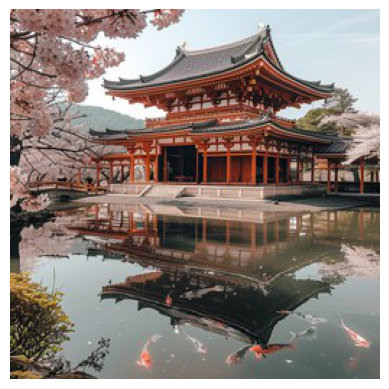

In [6]:
content_im = download_image(img1).to(def_device)
print('content_im.shape: ', content_im.shape)
show_image(content_im);

In [7]:
# check bounds
content_im.min(), content_im.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

## **Optimizing Images**

We will begin by optimizing the raw pixels of an image, which is a pretty straight forward task when compared to optimizing weights in a neural network.

Here, we won't be working with large numbers of training samples and will use 1 sample for the baseline line and 1 sample for the style transfer portion.

In [8]:
# The model won't be working with tons of images. With 1 baseline and 1 style sample, we need to initialize 
# the dataloader in a way that it allows the model to update gradients in a stepwise manner by literally 
# transferring the style of one image to another.
class LengthDataset():
    def __init__(self, length=1): self.length = length

    def __len__(self): return self.length
    
    def __getitem__(self, idx): 
        # Return 0,0 to pass a dummy item to the Learner
        # We don't care about the dataset itself.
        return 0, 0

def get_dummy_dls(length=100):
    # Allows the dataloader to pass fake dataset of 100 items to the model to carry out a number of steps.
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Training set
                       DataLoader(LengthDataset(1), batch_size=1))      # Validation with length 1

The `TensorModel` just passes a tensor / image to `nn.Parameter` in this instance since we aren't actually optimizing a model. We are optimizing an image, or more precisely, the _pixels of an image_ directly.

In [9]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())

    def forward(self, x=0): 
        # Passing x so that our Learner works as intended.
        return self.t

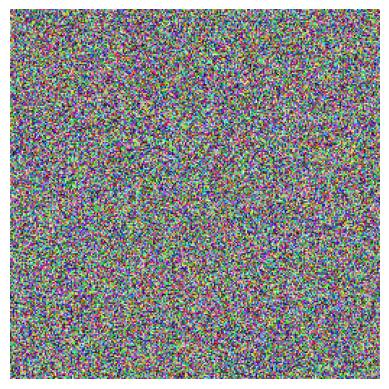

In [10]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [11]:
# To verify
print(model.t.requires_grad);  [p.shape for p in model.parameters()]

True


[torch.Size([3, 256, 256])]

We can also use `TrainCB` to setup the image optimizer. This would be preferred if we needed to pass in a larger number of parameters to the model.

In [12]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model() # Return image being optimized

    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds) # Evaluate by simply taking an image.

In [13]:
def loss_fn_mse(im):
    # Return loss of the content image and the target.
    return F.mse_loss(im, content_im)

In [14]:
model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, lr=1e-2,
               cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(2)

loss,epoch,train
0.031,0,train
0.001,0,eval
0.000,1,train
0.000,1,eval


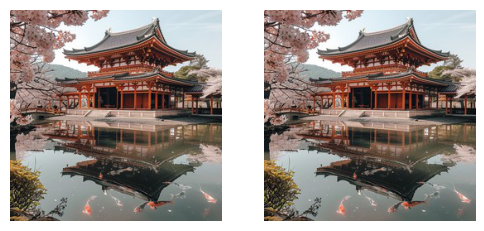

In [15]:
# Result (left) vs target image(right)
show_images([learn.model().clip(0, 1), content_im]);

### **View Progress**

This callback will allow us to see the training progress for the target moving from noise to a replica of the original sample. The images are logged every few iterations in `after_fit`.

In [16]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images = [] ; self.i = 0

    def after_batch(self, learn):
        if self.i % self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1

    def after_fit(self, learn): show_images(self.images)

loss,epoch,train
0.021,0,train
0.000,0,eval


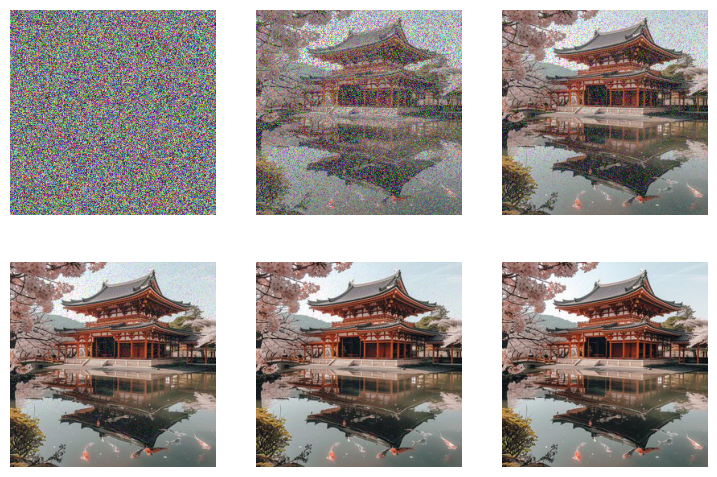

In [17]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, lr=1e-2,
                cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

## **Using VGG16 for Feature Extraction**

We'll use VGGNet for feature extraction. In particular, we will be extracting features from different layers of the network.

The VGG architecture stands for Visual Geometry Group, which consists of either 16 or 19 convolutional layers. Used primarily for classification tasks, VGG16 has an image input size of **224x244**. For full details on the model, read the paper titled ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556v6).


The interesting here is that the model flattens the final `7x7x512` layer into a linear layer `1x1x4096` and then to `1x1x1000`. This ends up being quite memory intensive. Also, to get a sense of how different layers maximize their activations to learn different features from their inputs, this [classic article on feature visualization](https://distill.pub/2017/feature-visualization/) is a must read.

![title](imgs/vgg-neural-network-architecture.png)

In [18]:
# VGG has numerous versions in the timm library
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [19]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [20]:
# This is the network architecture.
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### **Normalize Images**